# Reading from a CSV

## Install

In [1]:
SYFT_VERSION = ">=0.8.2.b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# %pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html

In [2]:
import syft as sy
sy.requires(SYFT_VERSION)

✅ The installed version of syft==0.8.2b2 matches the requirement >=0.8.2b0 and the requirement <0.9


In [3]:
node = sy.orchestra.launch(name="pandas-test-domain-1", port=7081, reset=True)

Starting pandas-test-domain-1 server on 0.0.0.0:7081


Waiting for server to start Done.


# Data owner: Upload data

In [4]:
root_domain_client = node.login(email="info@openmined.org", password="changethis")

Logged into pandas-test-domain-1 as <info@openmined.org>


## Load data

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.parser import parse
from pandas._libs.tslibs.timestamps import Timestamp
from syft import autocache
from syft.util.util import PANDAS_DATA

In [6]:
data_path = autocache(f"{PANDAS_DATA}/bikes.csv")

In [7]:
broken_df = pd.read_csv(data_path, encoding = "ISO-8859-1")

In [8]:
broken_df

,Date;Berri 1;Brébeuf (données non disponibles);Côte-Sainte-Catherine;Maisonneuve 1;Maisonneuve 2;du Parc;Pierre-Dupuy;Rachel1;St-Urbain (données non disponibles)
0,01/01/2012;35;;0;38;51;26;10;16;
1,02/01/2012;83;;1;68;153;53;6;43;
2,03/01/2012;135;;2;104;248;89;3;58;
3,04/01/2012;144;;1;116;318;111;8;61;
4,05/01/2012;197;;2;124;330;97;13;95;
...,...
305,01/11/2012;2405;;1208;1701;3082;2076;165;2461
306,02/11/2012;1582;;737;1109;2277;1392;97;1888
307,03/11/2012;844;;380;612;1137;713;105;1302
308,04/11/2012;966;;446;710;1277;692;197;1374


In [9]:
assert len(broken_df) == 310

In [10]:
fixed_df = pd.read_csv(data_path, sep=';', encoding='latin1', parse_dates=['Date'], dayfirst=True, index_col='Date')
fixed_df[:3]

,Berri 1,Brébeuf (données non disponibles),Côte-Sainte-Catherine,Maisonneuve 1,Maisonneuve 2,du Parc,Pierre-Dupuy,Rachel1,St-Urbain (données non disponibles)
Date,,,,,,,,,
2012-01-01,35,NaN,0,38,51,26,10,16,NaN
2012-01-02,83,NaN,1,68,153,53,6,43,NaN
2012-01-03,135,NaN,2,104,248,89,3,58,NaN


In [11]:
assert len(fixed_df) == 310

In [12]:
import numpy as np
from random import randint

def get_mock_int(i, var=10):
    base = 100 + int(np.cos(i/10) * 50)
    return randint(max(base-var, 1),max(1, base+var))

def get_mock_date(i):
    return str(parse('Jun 1 2005').date() + timedelta(days=i))

# some randomness
r = [(randint(1, 40), randint(1, 40)) for _ in range(7)]

def get_mock_row(i):
    res = [get_mock_int(i+r[j][0], r[j][1]) for j in range(7)]
    # add NaNs in the second and 10th col
    res.insert(1, None), res.insert(9, None)
    return res
    

In [13]:
mock = pd.DataFrame(index=[Timestamp(get_mock_date(i)) for i in range(len(fixed_df))],
                    data=[get_mock_row(i) for i in range(len(fixed_df))],
                    columns=fixed_df.columns)

Upload the data

In [14]:
dataset = sy.Dataset(name="test",
                     asset_list=[sy.Asset(name="bikes", data=fixed_df, mock=mock, mock_is_real=False)])
root_domain_client.upload_dataset(dataset)


  0%|          | 0/1 [00:00<?, ?it/s]

Uploading: bikes


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

<class 'syft.service.response.SyftSuccess'>: Dataset uploaded to 'pandas-test-domain-1'. To see the datasets uploaded by a client on this node, use command `[your_client].datasets`

## Create user account

In [15]:
user = root_domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

In [16]:
# todo: give user data scientist role

In [17]:
guest_domain_client = node.client

In [18]:
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

Logged into pandas-test-domain-1 as <jane@caltech.edu>


# Data scientist: request execution

## Download mock and submit a syft_function

### Get mock

In [19]:
guest_domain_client = node.client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

Logged into pandas-test-domain-1 as <jane@caltech.edu>


In [20]:
ds = guest_domain_client.datasets[0]

In [21]:
asset = ds.assets["bikes"]

In [22]:
df = asset.mock

### Selecting a column

When you read a CSV, you get a kind of object called a DataFrame, which is made up of rows and columns. You get columns out of a DataFrame the same way you get elements out of a dictionary.

Here's an example:

In [23]:
df['Berri 1']

2005-06-01    53
2005-06-02    69
2005-06-03    69
2005-06-04    22
2005-06-05    55
              ..
2006-04-02    72
2006-04-03    93
2006-04-04    96
2006-04-05    45
2006-04-06    39
Name: Berri 1, Length: 310, dtype: int64

### Plotting a column

Just add .plot() to the end! How could it be easier? =)

We can see that, unsurprisingly, not many people are biking in January, February, and March,

<Axes: >

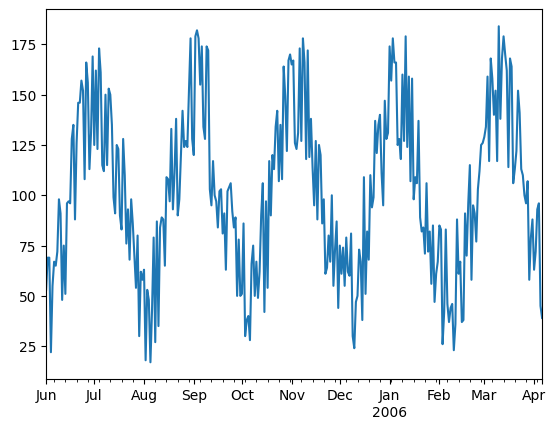

In [24]:
df['Berri 1'].plot()

We can also plot all the columns just as easily. We'll make it a little bigger, too. You can see that it's more squished together, but all the bike paths behave basically the same -- if it's a bad day for cyclists, it's a bad day everywhere.

<Axes: >

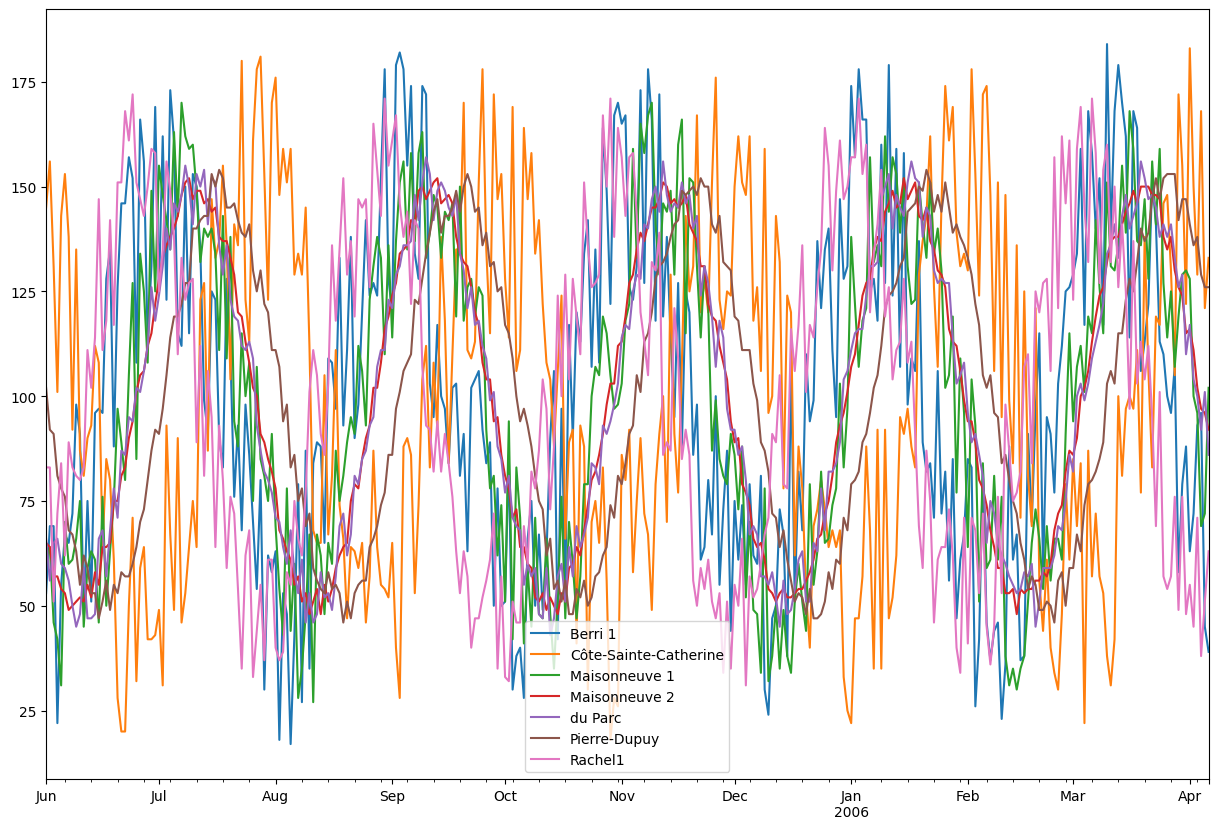

In [25]:
df.plot(figsize=(15, 10))

### Putting that all together

Here's the code we needed to write do draw that graph, all together:



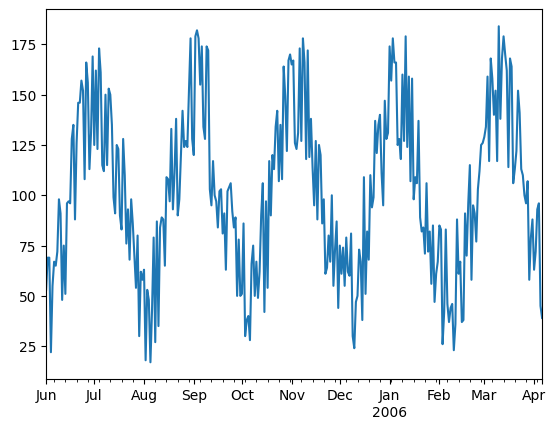

In [26]:
res = df['Berri 1'].plot()

In [27]:
@sy.syft_function(input_policy=sy.ExactMatch(df=asset),
                  output_policy=sy.SingleExecutionExactOutput())
def get_column(df):
    return df['Berri 1']

Syft function 'get_column' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.


Create and submit project

In [28]:
new_project = sy.Project(
    name="My pandas project 1",
    description="Hi, I would like to plot the Berri 1 column.",
    members=[guest_domain_client],
)
new_project

syft.service.project.project.ProjectSubmit

In [29]:
project = new_project.start()
assert isinstance(project, sy.service.project.project.Project)
project

syft.service.project.project.Project

In [30]:
project.create_code_request(get_column, guest_domain_client)

<class 'syft.service.response.SyftSuccess'>: Code request for 'get_column' successfully added to 'My pandas project 1' Project. To see code requests by a client, run `[your_client].code`

In [31]:
assert len(guest_domain_client.code.get_all())==1

In [32]:
assert len(project.events) == 1

In [33]:
assert isinstance(project.events[0], sy.service.project.project.ProjectRequest)

# Data owner: execute function

## Get messages

In [34]:
domain_client = node.client.login(email="info@openmined.org", password="changethis")

Logged into pandas-test-domain-1 as <info@openmined.org>


In [35]:
messages = domain_client.api.services.messages.get_all_unread()

In [36]:
messages

[syft.service.message.messages.Message, syft.service.message.messages.Message]

In [37]:
from syft.service.project.project import Project

In [38]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]
project_message

```python
class Message:
  id: str = b6a66da5bee7492db34f65c3d40ca724
  subject: str = "A new request has been added to the Project: My pandas project 1."
  status: str = MessageStatus.UNREAD
  created_at: str = 2023-06-29 09:47:37
  linked_obj: str = <<class 'syft.service.project.project.Project'>: 5990527f6c844e2f9d4b1b15c18c0551@<Node: 6fb36ffcad444570b3483fa6f4f8d39d>

```

In [39]:
request = project_message.link.events[0].request

In [40]:
func = request.changes[0].link
op = func.output_policy_type

In [41]:
func

```python
class UserCode
    id: str = 434669e119c444adb19b7dcf4f3108bf
    status.approved: str = False
    service_func_name: str = get_column
    code:

@sy.syft_function(input_policy=sy.ExactMatch(df=asset),
                  output_policy=sy.SingleExecutionExactOutput())
def get_column(df):
    return df['Berri 1']

```

In [42]:
get_col_user_function = func.unsafe_function

In [43]:
real_data = domain_client.datasets[0].assets[0].data

In [44]:
real_result = get_col_user_function(df=real_data)

In [45]:
real_result[:3]

Date
2012-01-01     35
2012-01-02     83
2012-01-03    135
Name: Berri 1, dtype: int64

In [46]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [47]:
asset = guest_client.datasets[0].assets[0]

In [48]:
guest_client.code[0].status

{NodeView(node_name='pandas-test-domain-1', verify_key=95e438cb8521b4cc1f35d4393fc4c0c188ccf1e45739f126ca8a326871d8a73a): <UserCodeStatus.EXECUTE: 'execute'>}

In [49]:
result_ptr = guest_client.code.get_column(df=asset)

<Axes: >

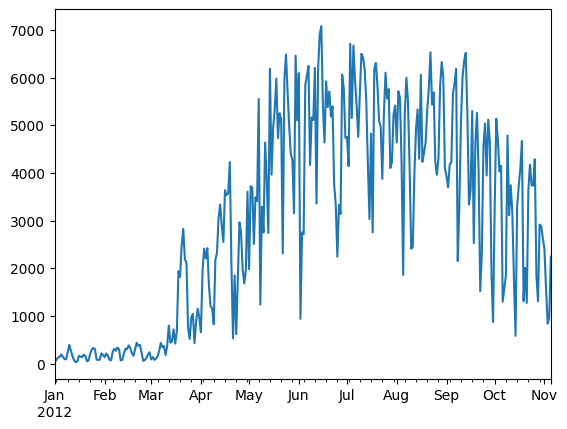

In [50]:
real_result = result_ptr.get()
real_result.plot()

In [51]:
node.land()

Stopping pandas-test-domain-1
